In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

IMG_SIZE = 96

In [2]:
def extract_label(img_path,train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')

    if train:
      gender, lr, finger, _, _ = etc.split('_')
    else:
      gender, lr, finger, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1

    if finger == 'thumb':
      finger = 0
    elif finger == 'index':
      finger = 1
    elif finger == 'middle':
      finger = 2
    elif finger == 'ring':
      finger = 3
    elif finger == 'little':
      finger = 4
    return np.array([gender], dtype=np.uint16)

In [3]:
def loading_data(path,boolean):
    data = []
    for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img),boolean)
            
            data.append([label[0], img_resize ])
            if len(data) % 1000 == 0:
                print(len(data))
    return data

In [4]:
Real_path = "./Real"
Easy_path = "./Altered/Altered-Easy"
Medium_path = "./Altered/Altered-Medium"
Hard_path = "./Altered/Altered-Hard"

Easy_data = loading_data(Easy_path,True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [5]:
# append the data and labels to the respective lists
img, labels = [], []
for label, feature in Easy_data:
    labels.append(label)
    img.append(feature)

In [6]:
train_data = np.array(img).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_data = train_data / 255.0

In [7]:
from keras.utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)

In [8]:
labels = np.array(labels)

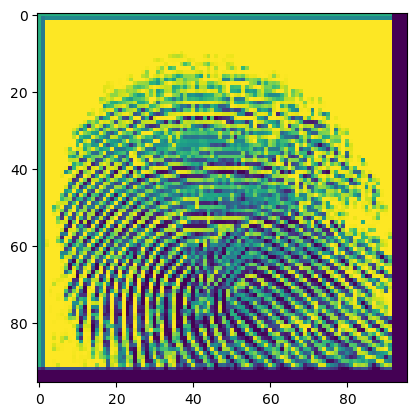

In [9]:
plt.imshow(train_data[5000])

In [10]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential([
Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
MaxPooling2D(2),
Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
MaxPooling2D(2),
Flatten(),
Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
Dense(1, activation = 'sigmoid'),
])
model.summary()


model.compile(optimizer = optimizers.Adam(1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)              

In [11]:
history = model.fit(train_data, labels, batch_size = 128, epochs = 13, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/13


113/113 [==============================] - 73s 617ms/step - loss: 0.7952 - accuracy: 0.7904 - val_loss: 0.4796 - val_accuracy: 0.7770
Epoch 2/13
113/113 [==============================] - 67s 592ms/step - loss: 0.4315 - accuracy: 0.8088 - val_loss: 0.5082 - val_accuracy: 0.7792
Epoch 3/13
113/113 [==============================] - 66s 582ms/step - loss: 0.4036 - accuracy: 0.8220 - val_loss: 0.4716 - val_accuracy: 0.7931
Epoch 4/13
113/113 [==============================] - 66s 589ms/step - loss: 0.3468 - accuracy: 0.8544 - val_loss: 0.5083 - val_accuracy: 0.7549
Epoch 5/13
113/113 [==============================] - 65s 572ms/step - loss: 0.2844 - accuracy: 0.8863 - val_loss: 0.4961 - val_accuracy: 0.7898
Epoch 6/13
113/113 [==============================] - 64s 568ms/step - loss: 0.2176 - accuracy: 0.9204 - val_loss: 0.5358 - val_accuracy: 0.7605
Epoch 7/13
113/113 [==============================] - 64s 569ms/step - loss: 0.1706 - accuracy: 0.9382 - val_loss: 0.6586 - val_

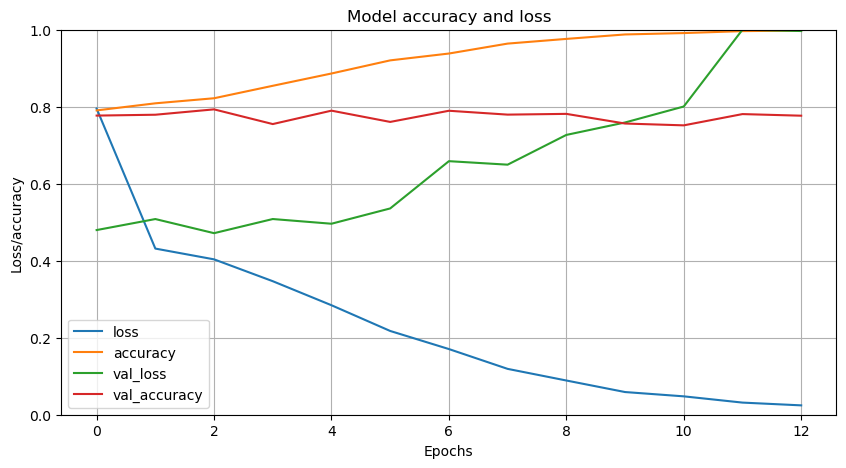

In [12]:
pd.DataFrame(history.history).plot(figsize = (10,5))
plt.grid(True)
plt.title('Model accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss/accuracy')
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
test_data = loading_data(Real_path,False)

x_test,y_test= [], []
for label, feature in test_data:
    y_test.append(label)
    x_test.append(feature)

1000
2000
3000
4000
5000
6000


In [14]:
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

188/188 [==============================] - 7s 35ms/step
6000


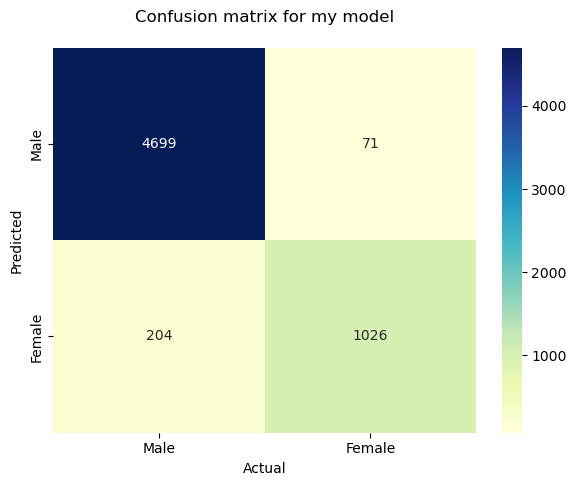

In [15]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 5))

preds = model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['Male', 'Female'], columns=['Male', 'Female'])
plt.subplot(121)
plt.title("Confusion matrix for my model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

print(len(y_test==1))


In [16]:
# Show True and Predicted values
for i in range(10):
    print('True: ', y_test[i])
    print('Predicted: ', model.predict(np.expand_dims(x_test[i], 0))[0])
    

True:  0
1/1 [==============================] - 0s 41ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 38ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 32ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 30ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 32ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 30ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 58ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 120ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 38ms/step
Predicted:  [0.]
True:  0
1/1 [==============================] - 0s 33ms/step
Predicted:  [0.]
